# 국민청원 웹스크랩핑 실습

## 패키지 설치하기

In [1]:
import pandas as pd 
import numpy as np 
from bs4 import BeautifulSoup as bs 
import requests


## 1. 웹스크랩핑 

기간 설정 : 20220101 - 20221231
항목 설정 
1. 동의종료 전체 청원 
2. 성립된 청원 
3. 미성립된 청원 

In [2]:
# 페이지 넘버 1번으로 설정해서 URL 출력 
# 기간 : 20220101 ~ 20221231로 수정 
# 1. 동의종료 전체 청원 : sort=AGRE_END_DE-
# 2. 성립된 청원 : sort=PETIT_REPT_DT-
# 3. 미성립된 청원 : sort=PETIT_END_DT-

# 1,2,3번 URL의 차이
# sort 값 다름 
# sttusCode부터 beginDate 전까지 다름 

In [3]:
# 서로 다른 값을 지정할 수 있는 값들 청원별로 정리해서 dictionary 형태에 저장 
guide_key = {
    "동의종료 전체 청원": ["sort=AGRE_END_DE-","sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE"],
    "성립된 청원" : ["sort=PETIT_RCEPT_DT-", "sttusCode=PETIT_FORMATN,CMIT_FRWRD"],
    "미성립된 청원" : ["sort=PETIT_END_DT-", "sttusCode=PETIT_END&resultCode=PETIT_INADQT,AGRE_END_DSUSE"]}

In [4]:
# 1번 페이지에 청원 종류를 "미성립된 청원"을 출력한 에시 
page_no = 1
petition_status = "동의종료 전체 청원"
url = f"https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&"
url = f"{url}recordCountPerPage=8&{guide_key[petition_status][0]}&searchCondition=sj&"
url = f"{url}searchKeyword=&petitRealmCode=&{guide_key[petition_status][1]}&beginDate=20220101&endDate=20221231&ageCd="

In [5]:
# 성공적으로 출력된 거 확인 
url

'https://petitions.assembly.go.kr/api/petits?pageIndex=1&recordCountPerPage=8&sort=AGRE_END_DE-&searchCondition=sj&searchKeyword=&petitRealmCode=&sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE&beginDate=20220101&endDate=20221231&ageCd='

In [6]:
# inspect -> 네트워크 -> FETCH/XHR에서 데이터 보유 URL 가져오기 
# json 형태로 저장 
# 데이터 프레임 생성 
response = requests.get(url)
petition_json = response.json()
df = pd.DataFrame(petition_json)

In [7]:
# 페이지 고유 번호 수집
page_num = df["petitId"]

In [9]:
page_num

0    E1F0409854026C45E054B49691C1987F
1    E2059AE3B2344B1BE054B49691C1987F
2    E1F0409853F96C45E054B49691C1987F
3    E1F0409853F26C45E054B49691C1987F
4    E203F8AB7F384B18E054B49691C1987F
5    E1F0409853DF6C45E054B49691C1987F
6    E1F01D9BE93A6C4BE054B49691C1987F
7    EB0E1E2D986D1CA1E054B49691C1987F
Name: petitId, dtype: object

In [10]:
# 내부페이지 JSON URL 수집 
page_num1 = page_num[0]
inside_url = f"https://petitions.assembly.go.kr/api/petits/{page_num1}?petitId={page_num1}&sttusCode="
inside_url

'https://petitions.assembly.go.kr/api/petits/E1F0409854026C45E054B49691C1987F?petitId=E1F0409854026C45E054B49691C1987F&sttusCode='

In [11]:
# 내부페이지 URL로 출력  
response2 = requests.get(inside_url)
petition_inside_json = response2.json()
# 각 페이지를 json 형식으로 바꿨을 때 pd.DataFrame을 해도 빈 데이터 프레임으로 나왔다. 
# 이 이유는 한 페이지의 값만을 데이터 프레임으로 바꿔서 그럼 따라서 모든 페이지의 값을 리스트에 넣고 데이터 플레임으로 만들어 줘야함 

### 1-1 함수 만들기

In [9]:
# 위에 한 내용 함수로 만들기 

def make_dataframe(page_no, petition_status):
    
    # 청원 종류 지정할 수 있는 고유 URL 값을 가진 Dictionary
    guide_key = {
    "동의종료 전체 청원": ["sort=AGRE_END_DE-","sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE"],
    "성립된 청원" : ["sort=PETIT_RCEPT_DT-", "sttusCode=PETIT_FORMATN,CMIT_FRWRD"],
    "미성립된 청원" : ["sort=PETIT_END_DT-", "sttusCode=PETIT_END&resultCode=PETIT_INADQT,AGRE_END_DSUSE"]}
    
    # 빈 리스트
    url_list =[]
    json_list = []
    
    # 수집에 필요한 Column 값 
    col = ["petrNm", "petitSj", "petitObjet", "petitCn", 
       "petitRealmNm", "resultCodeNm","petitEndDt", "agreBeginDe", "agreEndDe", "agreCo"]
    
    # 각 게시물의 고유 아이디를 담고 있는 url , json 형식으로 받기 
    url = f"https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&"
    url = f"{url}recordCountPerPage=8&{guide_key[petition_status][0]}&searchCondition=sj&"
    url = f"{url}searchKeyword=&petitRealmCode=&{guide_key[petition_status][1]}&beginDate=20220101&endDate=20221231&ageCd="
    response = requests.get(url)
    petition_json = response.json()
    df = pd.DataFrame(petition_json)
    
    # 페이지 고유 번호 수집 
    page_num = df["petitId"]
    
    # 내부페이지 JSON URL 수집 
    for i in page_num:
        inside_url = f"https://petitions.assembly.go.kr/api/petits/{i}?petitId={i}&sttusCode="
        url_list.append(inside_url)
    
    # 수집된 데이터 json 형식으로 데이터 출력해서 리스트 생성 
    for i in url_list:
        response2 = requests.get(i)
        petition_inside_json = response2.json()
        json_list.append(petition_inside_json)
    
    # 데이터 프레임으로 합치기 
    data_list = pd.DataFrame(json_list)
    
    # 필요한 컬럼으로 출력 
    data_list = data_list[col]
    
    # 컬럼값 이름 변경 
    data_list.rename(columns={"petrNm":"청원인", "petitSj": "청원명", "petitObjet":"청원의 취지",
                     "petitCn":"청원의 내용", "petitRealmNm":"청원분야", 
                     "resultCodeNm":"청원결과","petitEndDt":"청원종료일", 
                     "agreBeginDe":"청원동의시작일", "agreEndDe":"청원동의종료일", 
                     "agreCo":"청원 동의수"}, inplace=True)
    
    
    return data_list 
        
        

In [10]:
make_dataframe(1, "동의종료 전체 청원")

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
5,김**,기업의 과대포장에 관한 청원,1) 과대포장 문제를 해결하기 위함입니다.\r\n2) 국가의 일회용품 소비를 줄이기...,환경 문제가 날이 갈수록 심화되고 있습니다. 세계가 노력하고 있지만 여전히 부족하며...,재난/안전/환경,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:37:57,2022-12-28 23:59:59,157
6,박**,크론병을 앓고 있는 아들의 건강보험 적용 요청에 관한 청원,크론병 환자의 건강보험 적용에 대한 건의,저의 아들은 크론병을 앓고 있습니다.\r\n크론병 치료나 완화에 사용되는 약 또는 ...,보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:26,2022-12-28 23:59:59,650
7,길**,난임부부지원 횟수의 확대 및 시험관 지원에 관한 청원,난임부부지원 횟수의 확대,저는 아직 시험관을 시작하지 않은 결혼 2년차인 여성입니다.\r\n \r\n늦은 결...,저출산/고령화/아동/청소년/가족,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:37:29,2022-12-28 23:59:59,567


### 1-2 반복문을 사용해 전체 데이터 출력하기 

동의 종료 전체 청원에서 22년도 데이터 저장 (for문 사용)

In [11]:
from tqdm import trange
import time

# 경고메시지가 있으면 tqdm 로그가 너무 많이 찍히기 때문에 경고메시지를 제거합니다.
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

petition_list = []
last_page = 43

for page_no in trange(1, last_page + 1):
    temp = make_dataframe(page_no, "동의종료 전체 청원")
    petition_list.append(temp)
    time.sleep(0.01)

100%|███████████████████████████████████████████| 43/43 [01:19<00:00,  1.86s/it]


In [14]:
# pd.concat으로 데이터 합치기
petition_list_22 = pd.concat(petition_list, ignore_index = True)
petition_list_22

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
334,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:47:48,2022-01-12 23:59:59,429
335,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
336,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034
337,하**,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:22:35,2022-01-06 23:59:59,210


## 2. 데이터 전처리 


### 분야별 청원 개수 

시각화 패키지 가져오기

In [15]:
import matplotlib.pyplot as plt

In [16]:
petition_list_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   청원인      339 non-null    object
 1   청원명      339 non-null    object
 2   청원의 취지   339 non-null    object
 3   청원의 내용   339 non-null    object
 4   청원분야     339 non-null    object
 5   청원결과     339 non-null    object
 6   청원종료일    339 non-null    object
 7   청원동의시작일  339 non-null    object
 8   청원동의종료일  339 non-null    object
 9   청원 동의수   339 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 26.6+ KB


In [17]:
# 수치형 통계
# 총 동의 수는 5만인데 최대값이 100000인 청원 발견 
petition_list_22.describe()

,청원 동의수
count,339.000000
mean,6306.053097
std,14732.770807
min,108.000000
25%,214.500000
50%,473.000000
75%,2505.000000
max,100000.000000


In [18]:
# 범주형 통계
petition_list_22.describe(include="O")

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일
count,339,339,339,339,339,339,339,339,339
unique,55,334,335,338,18,4,117,339,117
top,김**,코로나 백신 접종 중단과 부작용 피해 조사에 관한 청원,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 \n설치 등 특정 목적을 관철 ...,# 관련 파일 첨부 참조 요망 #\n제2조(정의) 이 법에서 사용하는 용어의 뜻은 ...,보건의료,동의만료폐기,2022-09-01 00:01:00,2022-11-30 09:52:01,2022-08-31 23:59:59
freq,60,3,4,2,57,311,13,1,13


In [88]:
petition_list_22 = petition_list_22.drop_duplicates(['청원명'])
petition_list_22 = petition_list_22.drop_duplicates(['청원의 취지'])

In [89]:
# 범주형 통계
petition_list_22.describe(include="O")

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일
count,331,331,331,331,331,331,331,331,331
unique,55,331,331,331,18,4,117,331,117
top,김**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,보건의료,동의만료폐기,2022-09-01 00:01:00,2022-11-30 09:52:01,2022-08-31 23:59:59
freq,60,1,1,1,53,303,13,1,13


인사이트 
- 청원인에서 frequency 값이 60인건 이름이 마스킹 처리가 되어있어서 김씨 성을 가진 사람이 60명이 되는 것 같다
- frequency가 동일한 청원명이 3개, 동일한 청원의 취지가 2개 그리고 동일한 청원의 내용이 2개 이므로 중복해서 청원을 한 사람들이 있는 것으로 보여진다 

Box Plot으로 표현해본 결과 이상치가 있는걸 확인했습니다

Text(0.5, 0, 'Agreements')

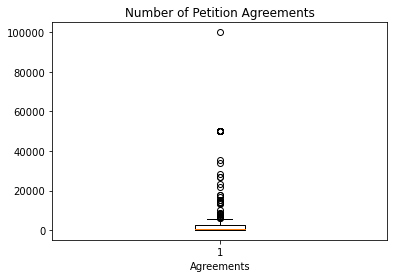

In [19]:
plt.boxplot(petition_list_22["청원 동의수"])
plt.title("Number of Petition Agreements")
plt.xlabel("Agreements")

In [91]:
# 100000인 청원이 outlier로 발견됬다. 따라서 100000이 넘은 청원은 청원이 끝난 건수 이므로 50000으로 바꿔준다
petition_list_22.loc[petition_list_22["청원 동의수"]==100000, "청원 동의수"] = 50000

이상치 제거를 제거해 주었습니다

Text(0.5, 0, 'Agreements')

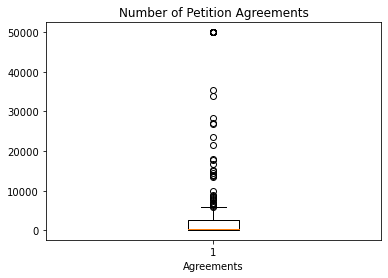

In [92]:
plt.boxplot(petition_list_22["청원 동의수"])
plt.title("Number of Petition Agreements")
plt.xlabel("Agreements")

## 3. 데이터 분석

동의가 성립된 경우는 청원 동의수가 50000인 청원입니다. 청원 요건이 충족된 데이터 값을 가진 데이터 프레임을 생성하겠습니다

In [93]:
df_success = petition_list_22.loc[petition_list_22["청원 동의수"] == 50000]

In [94]:
# 
pd.crosstab(df_success["청원분야"], df_success["청원결과"])

청원결과,본회의불부의,위원회심사,위원회접수후철회
청원분야,,,
과학기술/정보통신,1,0,0
농업/임업/수산업/축산업,0,1,0
문화/체육/관광/언론,0,1,0
보건의료,0,4,0
산업/통상,0,3,0
수사/법무/사법제도,0,6,0
인권/성평등/노동,0,5,0
재난/안전/환경,0,1,0
재정/세제/금융/예산,0,1,0


성립되지 않은 청원을 df_fail로 데이터 프레임 만들기

In [95]:
df_fail = petition_list_22.loc[petition_list_22["청원 동의수"] < 50000]

In [96]:
df_fail

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
329,박**,코로나 백신 특검 요청에 관한 청원,"너무나도 많은 국민이 백신 부작용으로 큰 피해를 보고 있고, 정작 최선의 대안은 백...",에코헬스 얼라이언스(EcoHealth Alliance)의 회장 피터 다작(Peter...,수사/법무/사법제도,동의만료폐기,2022-01-21 00:01:00,2021-12-21 09:41:41,2022-01-20 23:59:59,27092
333,조**,농림축산식품부의 고양이 중성화사업 실시 요령 고시 개정에 관한 청원,청원의 취지자는 수년 간 반려동물들과 함께 살며 길고양이들을 관리해 온 사람입니다....,본 청원의 고시내용 철회를 요청하는 내용에 대해 말씀드리겠습니다.\n\n1.\n『제...,기타,동의만료폐기,2022-01-17 00:01:00,2021-12-17 09:54:22,2022-01-16 23:59:59,313
335,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
336,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034


(array([261.,  18.,   7.,   4.,   5.,   1.,   2.,   2.,   1.,   2.]),
 array([  108. ,  3627.5,  7147. , 10666.5, 14186. , 17705.5, 21225. ,
        24744.5, 28264. , 31783.5, 35303. ]),
 <BarContainer object of 10 artists>)

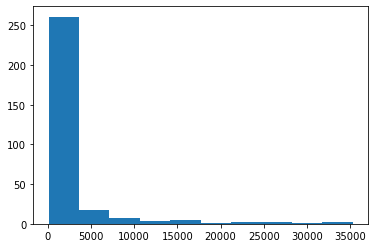

In [97]:
plt.hist(df_fail["청원 동의수"])

아이디어 1 - 월별 청원 개수 

In [125]:
petition_list_22.tail()

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
333,조**,농림축산식품부의 고양이 중성화사업 실시 요령 고시 개정에 관한 청원,청원의 취지자는 수년 간 반려동물들과 함께 살며 길고양이들을 관리해 온 사람입니다....,본 청원의 고시내용 철회를 요청하는 내용에 대해 말씀드리겠습니다.\n\n1.\n『제...,기타,동의만료폐기,2022-01-17 00:01:00,2021-12-17 09:54:22,2022-01-16 23:59:59,313
335,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
336,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034
337,하**,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:22:35,2022-01-06 23:59:59,210
338,김**,22년 3월 대선에서 수개표 시행을 위한 공직선거법 개정에 관한 청원,공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이 계속되고 있습니다. ...,1. ‘당일 투표’만 시행한다는 내용을 개정법안에 명시해 주십시오.\n\n부정선거의...,정치/선거/국회운영,위원회심사,2022-01-06 14:49:10,2021-12-07 16:22:05,2022-01-06 14:49:10,50000


In [139]:
petition_month = pd.DatetimeIndex(petition_list_22["청원동의시작일"]).month

In [142]:
new_list = {}
for i in petition_month:
    try: new_list[i] += 1
    except : new_list[i] = 1



In [155]:
sorted_list = sorted(new_list.items())
sorted_list = dict(sorted_list)
sorted_list


{1: 7,
 2: 4,
 3: 4,
 4: 9,
 5: 45,
 6: 54,
 7: 43,
 8: 31,
 9: 30,
 10: 43,
 11: 46,
 12: 15}

Text(0.5, 0, 'Month')

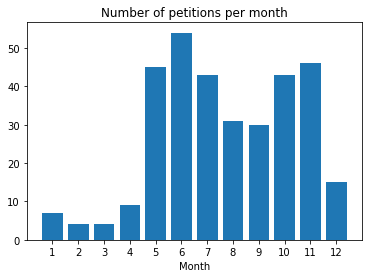

In [157]:
plt.bar(range(1,len(sorted_list)+1), list(sorted_list.values()))
plt.xticks(range(1,13))
plt.title("Number of petitions per month")
plt.xlabel("Month")